In [3]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Representing Data and Engineering Features

### Categorical Variables
In scikit-learn, all input features have to be numeric.  
To convert categorical variables, we have different options.

#### One-Hot-Encoding (Dummy variables)
Convert a feature with c categories to $c$ dummy variables:  

In [4]:
import os
# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
data = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_FOLDER, "adult.data"), header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# For illustration purposes, we only select some of the columns:
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
# IPython.display allows nice output formatting within the Jupyter notebook
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


##### Checking string-encoded categorical data

It is often good to first check if a column actually contains meaningful categorical data. 

For example, it might be that some people specified gender as “male” and some as “man,”

A good way to check the contents of a column is using the value_counts function of a pandas Series:

In [5]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


There is a very simple way to encode the data in pandas, using the `get_dummies` function.  

The get_dummies function automatically transforms all columns that have object type (like strings) or are categorical.

In [6]:
print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

In [7]:
display(data_dummies.head(n=2))

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,...,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,...,0,0,1,0
1,50,13,0,0,...,0,0,1,0


We can now use the values attribute to convert the data_dummies DataFrame into a NumPy array, and then train a machine learning model on it. 

Be careful to separate the target variable (which is now encoded in two income columns) from the data before training a model.

In [8]:
# Get only the columns containing features
# that is all columns from 'age' to 'occupation_ Transport-moving'
# This range contains all the features but not the target

features = data_dummies.ix[:, 'age':'occupation_ Transport-moving']
# extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


Now the data is represented in a way that scikit-learn can work with, and we can
proceed as usual:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


#### Numbers can encode categoricals

Often, whether for ease of storage or because of the way the data is collected, categorical variables are encoded as integers (e.g. questionnaires). 

They should not be modeled by a single continuous variable.

The get_dummies function in pandas treats all numbers as continuous and will not create dummy variables for them. 

To get around this, you can either 
- use scikit- learn’s OneHotEncoder, for which you can specify which variables are continuous and which are discrete
- or convert numeric columns in the DataFrame to strings.

In [10]:
# create a dataframe with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Categorical Feature,Integer Feature
0,socks,0
1,fox,1
2,socks,2
3,box,1


In [11]:
display(pd.get_dummies(demo_df))

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


In [12]:
demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
display(pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature']))

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


### Binning (Discretization)

The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using. 

Linear models and tree-based models (such as decision trees, gradient boosted trees, and random forests), have very different properties when it comes to how they work with different feature representations.

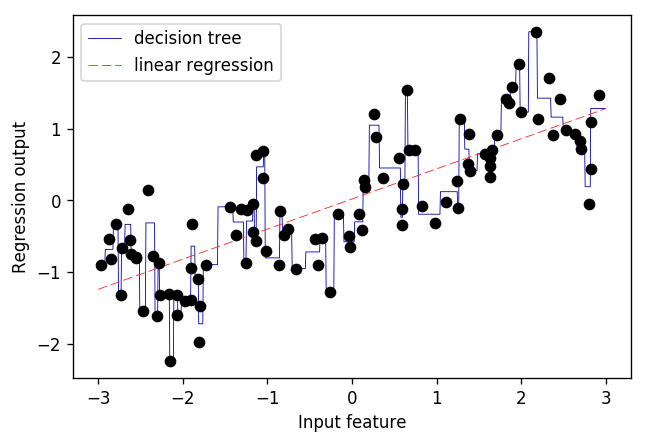

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

One way to make linear models more powerful on continuous data is to use binning (also known as discretization) of the feature to split it up into multiple features.

We imagine a partition of the input range for the feature (in this case, the numbers from –3 to 3) into a fixed number of bins—say, 10. A data point will then be represented by which bin it falls into.

These are the boundaries of the bins:

In [14]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


Numpy's `digitize` maps each value to its corresponding bin. E.g. the first sample goes to bin nr. 4.

In [15]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


To use a scikit-learn model on this data, we transform this discrete feature to a one-hot encoding using the OneHotEncoder from the preprocessing module. 

The OneHotEncoder does the same encoding as pandas.get_dummies, though it currently only works on categorical variables that are integers. 

As with all preprocessing operators in scikit-learn, we first call `fit` to compute the internal parameters of the transformation, and then `transform` to produce the transformed data. You can also run `fit_transform` to do both at once. 

Note that, when dealing with train-test splits, we often `fit` the preprocessor on the training data, and then apply it to both the training data and test data. The test data should _never_ be used to compute the preprocessing, because information about the test data will _leak_ into the training data, invalidating your model evaluation.

In [16]:
from sklearn.preprocessing import OneHotEncoder
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [17]:
print("X_binned.shape: {}".format(X_binned.shape))

X_binned.shape: (100, 10)


Now we build a new linear regression model and a new decision tree model on the one-hot-encoded data.

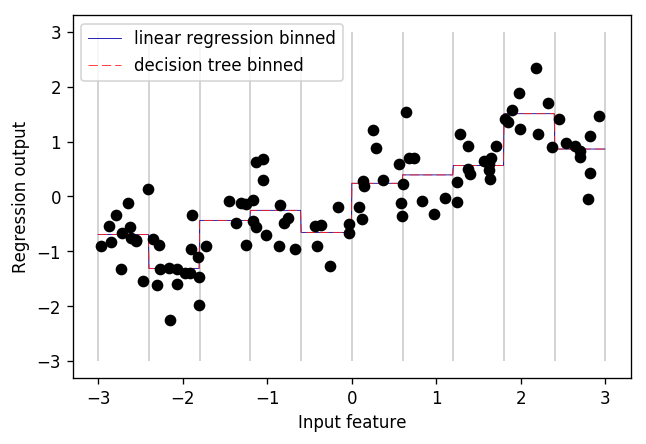

In [18]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

### Interaction features

Another way to enrich a feature representation, particularly for linear models, is adding interaction features and polynomial features of the original data.

For instance: our linear model learned a constant value for each bin in the wave dataset. If we want a sloped linear model we need to allow interaction with another feature, e.g., the original feature. So let's add the original feature (the x-axis in the plot) back in. This leads to an 11-dimensional dataset:

In [19]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(100, 11)


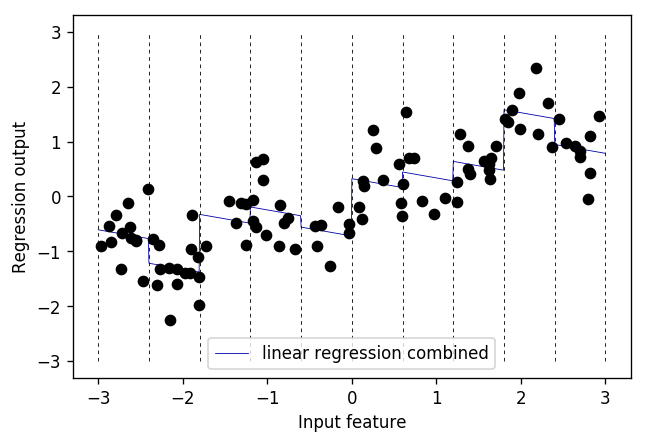

In [20]:

reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

With just one more degree of freedom, however, all bines have the same slope. If we want a different slope per bin, we need a new _interaction feature_ (or _product feature_) that indicates in which bin a data point is in __and__ where it lies on the x-axis. For instance, this feature could be the product of the bin indicator and the original feature.

In [21]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


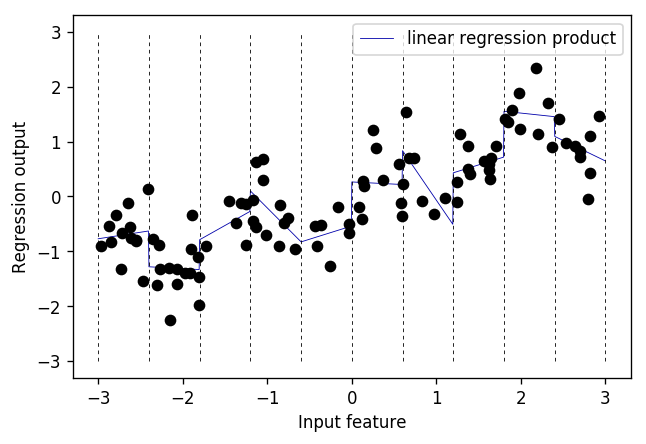

In [22]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

### Polynomials

We can also make linear models behave more flexibly by adding polynomials of the original continuous features. 

For a given feature x, we might want to consider $x^2$, $x^3$, $x^4$, and so on. In scikit-learn, this is implemented in `PolynomialFeatures` in the preprocessing module

In [23]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a features that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

Using a degree of 10 yields 10 features, with the original value raised to the n-th power.

In [24]:
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (100, 10)


In [25]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]
Entries of X_poly:
[[    -0.753      0.567     -0.427      0.321     -0.242      0.182
      -0.137      0.103     -0.078      0.058]
 [     2.704      7.313     19.777     53.482    144.632    391.125
    1057.714   2860.36    7735.232  20918.278]
 [     1.392      1.938      2.697      3.754      5.226      7.274
      10.125     14.094     19.618     27.307]
 [     0.592      0.35       0.207      0.123      0.073      0.043
       0.025      0.015      0.009      0.005]
 [    -2.064      4.26      -8.791     18.144    -37.448     77.289
    -159.516    329.222   -679.478   1402.367]]


In [26]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


Using polynomial features together with a linear regression model yields _polynomial regression_.

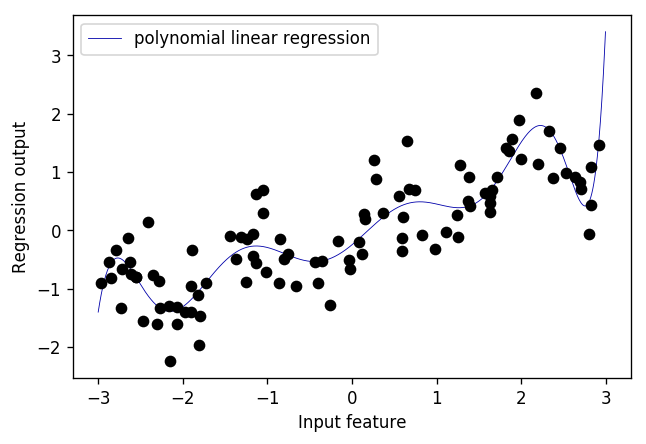

In [27]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As a comparison, here is a kernel SVM model learned on the original data, without any transformation

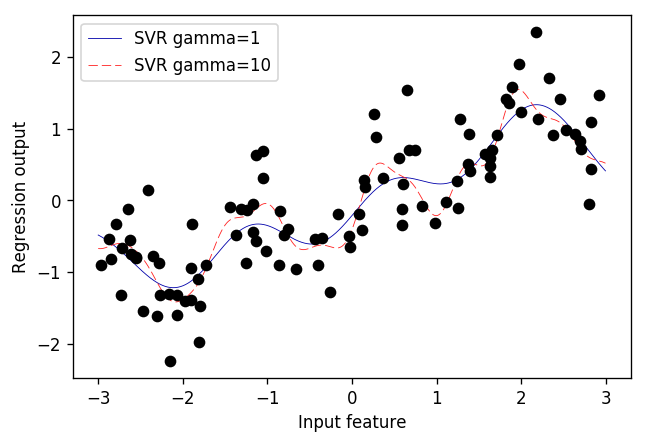

In [28]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

### Scaling

When the features have different scales (their values range between very different minimum and maximum values), it makes sense to scale them to the same range. Otherwise, one feature will overpower the others, expecially when raised to the $n$th power. (We saw the same issue with SVMs.)

We can rescale features between 0 and 1 using MinMaxScaler:

In [29]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

# rescale data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we extract polynomial features and interactions up to a degree of 2. Note how we `fit` the `PolynomialFeatures` only on the training data and then apply it (`transform`) on both the training and test data.

`PolynomialFeatures` will add a new features for each possible interaction (product) of up to 2 input features, including the products of a feature with itself (the squares). Hence, $\frac{13!}{11!  2!}$ + 13 + 13 features total.


In [30]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


The exact correspondence between input and output features can be found using the get_feature_names method:

In [31]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


Let’s compare the performance of a linear model (Ridge regression) on the data with and without interactions:

In [32]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
        ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


Clearly, the interactions and polynomial features gave us a good boost in performance when using Ridge. When using a more complex model like a random forest, the story is a bit different, though:

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.818
Score with interactions: 0.777


The random forest does not benefit from the interaction features, in fact, performance decreases...

Adding polynomials is typically good for linear models, but not a cure-for-all. Always evaluate the performance of models when adding preprocessing steps.

### Non-linear transformations

There are other transformations that often prove useful for transforming certain features.

For instance, `log` or `exp` are very useful to better scale your data. This is useful for models that are sensitive to feature scales, such as linear models, SVMs and neural networks.

The functions log and exp can help by adjusting the relative scales, tranforming them to more Gaussian-like value distributions.

Here we generate some data that has a very non-normal (Poisson) distribution:

In [53]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

In [35]:
print("Number of feature appearances:\n{}".format(np.bincount(X[:, 0])))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9 17
  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5  2  1
  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1  0  2  0
  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0  0  0  0  0
  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


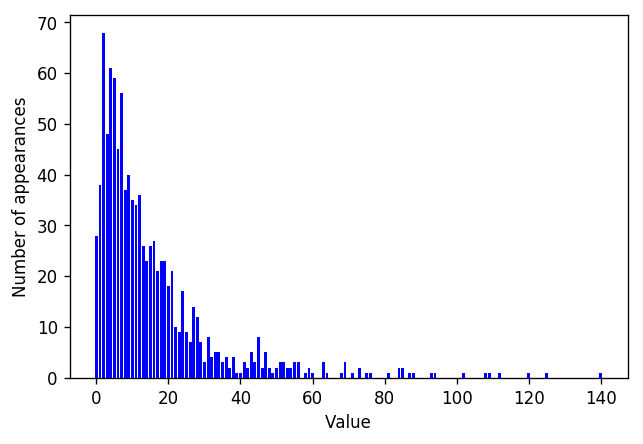

In [62]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

This is something most linear models can’t handle very well:

In [37]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


Applying a logarithmic transformation can help to create a more normal (Gaussian) distribution

In [38]:
# We actually compute log(x+1) to avoid the occurrence of log(0)
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

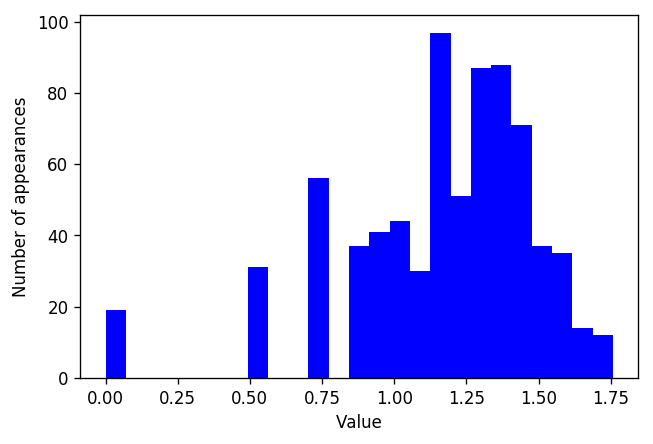

In [64]:
plt.hist(np.log(X_train_log[:, 0] + 1), bins=25, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value");

And our Ridge regressor now performs a lot better.

In [40]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


Finding the transformation that works best for each combination of dataset and model is somewhat of an art.

### Automatic Feature Selection

When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. This can lead to simpler models that generalize better, or help learning algorithms that are sensitive to the number of features (e.g. kNN).

#### Univariate statistics (ANOVA)

We want to keep the features for which there is statistically significant relationship between it and the target.
In the case of classification, this is also known as analysis of variance (ANOVA). These test consider each feature individually (they are univariate), and are completely independent of the model that you might want to apply afterwards.

To apply ANOVA, you need to choose a _test_, usually f_classif for classification or f_regression for regression. The result will be a p-value for each feature (lower is better). `SelectKBest` will only keep the $k$ features with the lowest p values. `SelectPercentile` selects a fixed percentage of features. 

To test these methods, we'll take the `breast_cancer` dataset, and add 50 random noise features. The feature selector should be able to remove at least these noise features.

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


We can retrieve which features were selected with `get_support`, and visualize the selected (black) and removed (white) features. `SelectPercentile` removed most of the noise features, but not perfectly.

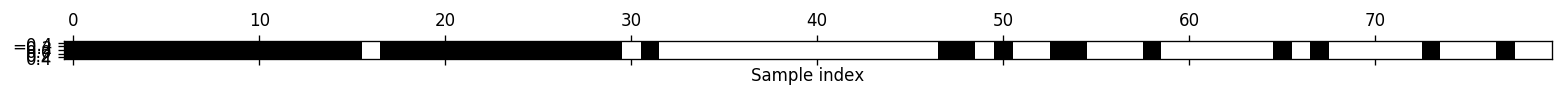

In [66]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

As usual, we need to check how the transformation affects the performance of our learning algorithms.

In [43]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


#### Model-based Feature Selection
Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. Compared to ANOVA, they consider all features together, and are thus able to capture interactions: a feature may be more (or less) informative in combination with others.

The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling, it only needs to be able to measure the (perceived) importance for each feature:

- Decision tree–based models return a `feature_importances_` attribute
- Linear models return coefficients, whose absolute values also reflect feature importance 

In scikit-learn, we can do this using `SelectFromModel`. It requires a model and a threshold. `threshold="median"` means that the median observed feature importance will be the threshold, which will remove 50% of the features.

We've seen before how RandomForests return good estimates of feature importance:

In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [45]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


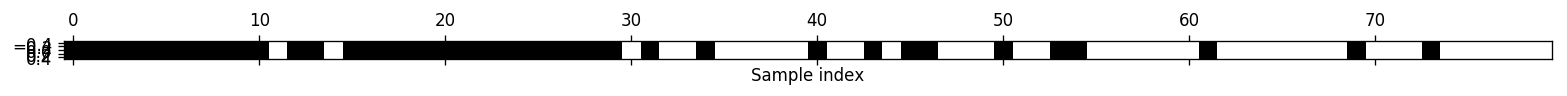

In [46]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

All but two of the original features were selected, and most of the noise features removed. Our linear model trained on the selected features also performs quite a bit better.

In [47]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


#### Iterative feature selection

Instead of building a model to remove many features at once, we can also just ask it to remove the worst feature, then retrain, remove another feature, etc. This is known as _recursive feature elimination_ (RFE).

Vice versa, we couls also ask it to iteratively add one feature at a time. This is called _forward selection_.

In both cases, we need to define beforehand how many features to select. When this is unknown, one often considers this as an additional hyperparameter of the whole process (pipeline) that needs to be optimized.

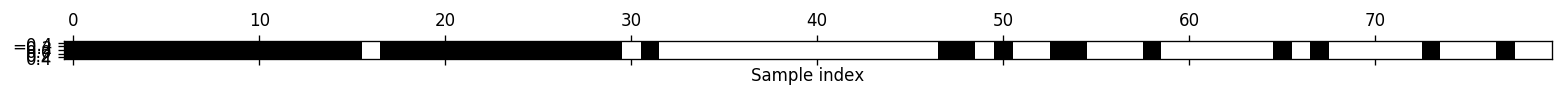

In [48]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [49]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [50]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


Automatic feature selection can be helpful when:

- You expect some inputs to be uninformative, and your model does not select features internally (as tree-based models do)
- You need to speed up prediction without loosing much accuracy
- You want a more interpretable model (with fewer variables)